In [2]:
%load_ext Cython
from numpy import linalg

In [56]:
%%cython
import numpy as np

class Particula:#En esta clase definimos los métodos fundamentales que debe seguir cada partícula

    def __init__(self, (float,float) posicion, (float,float) velocidad, float masa, float radio): 
       """comenzamos definiendo el método que debe 
        inicializar la clase, en este definimos los atributos básicos de la clase partícula
        las entradas masa y radio son de tipo float y las entradas de posición son tuplas conformadas por floats"""  
       self.radio=radio  
       self.masa=masa 
       
       self.posicion=np.array(posicion)   #Estas variables son arrays de numpy, y las trataremos como vectores
       self.velocidad=np.array(velocidad)
       self.velocidad_mag=np.linalg.norm(self.velocidad)#Este atributo no es otra cosa que la magnitud del vector velocidad
     
       """Creamos tres listas con los vectores posición y velocidad y velocidad_mag, posteriormente las usaremos
       para generar una lista con todos los valores que ha tenido la velocidad y posición"""
       
       self.velocidad_n=[self.velocidad]    ##Velocidad_n y posición_n son listas de vectores que contienen las listas correspondiente a
       self.posicion_n=[self.posicion]      ##todos los valores de estos vectores
       self.velocidad_mag_n=[self.velocidad_mag]
     
  ##########################################################################
    def paso_dt(self,float dt):   #Falta definir el valor que va a tomar dt  
       """Este método lo que hace es avanzar en el tiempo, cambia la posición de la partícula y agrega a las listas
       una actualización tanto de la posición de la partícula como la velocidad de la misma"""
      
       self.posicion=self.posicion + self.velocidad*dt  
       self.posicion_n.append(self.posicion) #Se añaden 
       self.velocidad_n.append(self.velocidad)
       self.velocidad_mag_n.append(self.velocidad_mag)
 ###############################################################################################
    def ver_colision_pp(self,otra_p):
       """Este método verifica si se dio luegar a una colisión entre dos partículas, las entradas
      son dos partículas, se definen sus radios y posiciones y se plantea una condición que indica 
      si las partículas chocaron"""
       cdef float r1=self.radio
       cdef float r2=otra_p.radio
       p1=self.posicion
       p2=otra_p.posicion
       cdef float sep=np.linalg.norm(p1-p2)#Norma del vector separación de ambas partículas.
       if sep-(r1+r2)<=0:#Si la separación es menor o igual a la suma de sus radios, entonces las partículas están en contacto y por lo tanto chocaron.
         return True
       else:
         return False
######################################################################################################
    def ver_colision_esquina(self, float Lx, float Ly):
       "Revisa si hay colisión con una esquina, Lx y Ly son las dimensiones horizontal y vertical de la caja respectivamente"
       extremo_izquierdo = self.posicion[0] - self.radio #da la posición del extremo izquido de la partícula
       extremo_inferior = self.posicion[1] - self.radio  #da la posición del extremo inferior de la partícula
       extremo_derecho  = self.posicion[0] + self.radio  #da la posición del extremo derech0 de la partícula
       extremo_superior = self.posicion[1] + self.radio  #da la posición del extremo superior de la partícula
       #Ahora construimos las variables donde se va a almacenar el hecho de chocar contra una esquina o no
       cdef bint choque_00 = extremo_izquierdo >0 and extremo_inferior> 0   #Esto corresponde a no chocar con la esquina (0,0)
       cdef bint choque_Lx0 = extremo_derecho <Lx and extremo_inferior > 0 #Esto corresponde a no chocar con la esquina (Lx,0)
       cdef bint choque_LxLy =  extremo_derecho <Lx and extremo_superior <Ly  #Esto corresponde a no chocar con la esquina (Lx,Ly)
       cdef bint choque_0Ly = extremo_izquierdo > 0 and extremo_superior <Ly  #Esto corresponde a chocar con la esquina (0,Ly)
       if not choque_00 or not choque_Lx0 or not choque_LxLy or not choque_0Ly:
         return  True 
       else:
         return False
       
        
#####################################################################################################
    def ver_colision_muro(self, float Lx, float Ly):
        """Este método revisa si la partícula ha chocado contra un muro."""
        """La condición ve que si la posición en "x" es diferente 0 o la longitud horizontal (Lx) de la caja y adicionalmente
     #  si la posición en "y" es diferente de 0 o la longitud vertical (Ly) entonces la partícula no está chocando contra un muro"""
        cdef bint choque_paredes_horizontal = self.posicion[0] + self.radio <Lx and  self.posicion[0] - self.radio!=0
        #ambas condiciones corresponden a no chocar con esas paredes
        cdef bint choque_paredes_verticales = self.posicion[1] + self.radio <Ly and  self.posicion[1] - self.radio !=0
        if  choque_paredes_horizontal and choque_paredes_verticales:
          return False
        else:
          return True 
        
######################################################################################################
    def resolver_colision_particula(self,otra_p):#Método que actualiza las velocidades de dos partículas después de chocar
      M1=self.masa    #Definimos las magnitudes a usar para resolver el choque
      M2=otra_p.masa
      p1=self.posicion
      p2=otra_p.posicion
      V1=self.velocidad
      V2=otra_p.velocidad
      if self.ver_colision_pp:
        self.velocidad= self.velocidad-((2*M2)/(M1+M2))*(np.dot(p1-p2,V1-V2)/(np.linalg.norm(p1-p2)**2))*(p1-p2)
        otra_p.velocidad= otra_p.velocidad-((2*M1)/(M1+M2))*(np.dot(p2-p1,V2-V1)/(np.linalg.norm(p2-p1)**2))*(p2-p1)
  

    def resolver_colision_muro(self,float Lx,float Ly): 
        """#Método que actualiza la velocidad después de que una partícula choca con un muro. Recibe la
        partícula y las dimensiones de la caja"""
        cdef bint choque_paredes_horizontal = self.posicion[0] + self.radio <Lx and  self.posicion[0] - self.radio!=0
        cdef bint choque_paredes_verticales = self.posicion[1] + self.radio <Ly and  self.posicion[1] - self.radio !=0
        if not choque_paredes_horizontal:
            self.velocidad[0] = -1 * self.velocidad[0]
        elif not choque_paredes_verticales:
            self.velocidad[1] =-1 * self.velocidad[1]
    
    def resolver_colision_esquina(self):
        """Método que actualiza la velocidad después de que una partícula choca con una esquina"""
        self.velocidad = -1* self.velocidad #se invierte todo el vector
            
        

In [9]:
#Prueba de ver_colision_muro
p1 = Particula((0,0),(3,4),1,0.5)
for j in range(10):
  p1.paso_dt(1)
  if p1.ver_colision_muro(20,20):
    print("se paró en muro")
    break
print(p1.posicion_n)

se paró en muro
[array([0., 0.]), array([3., 4.]), array([6., 8.]), array([ 9., 12.]), array([12., 16.]), array([15., 20.])]


In [59]:
#Prueba de ver_colision_esquina
p1 = Particula((,),(3,4),1,0.5)
for j in range(10):
  p1.paso_dt(1)
  if p1.ver_colision_esquina(9,12):
    print("se paró")
    break
print(p1.posicion_n)

se paró
[array([3., 2.]), array([6., 6.]), array([ 9., 10.])]


In [11]:
#Prueba de colision con dos partículas
p1=Particula((2,6),(1,0),2,1)
p2=Particula((4,6),(-1,0),2,1)
p1.resolver_colision_particula(p2)
print(p1.velocidad)
print(p2.velocidad)


[-1.  0.]
[1. 0.]


In [14]:
#Prueba de resolver_colision_muro
p1 = Particula((0,0),(3,4),1,0.5)
for j in range(10):
  p1.paso_dt(1)
  if p1.ver_colision_muro(20,20):
     p1.resolver_colision_muro(20,20)
     break
print(p1.posicion)
print(p1.velocidad)

[15. 20.]
[ 3. -4.]


In [18]:
#Prueba de resolver_colision_esquina
p1 = Particula((0,0),(3,4),1,0.5)
for j in range(10):
  p1.paso_dt(1)
  if p1.ver_colision_esquina(9,12):
     p1.resolver_colision_esquina()
     break
print(p1.posicion)
print(p1.velocidad)

[ 9. 12.]
[-3. -4.]


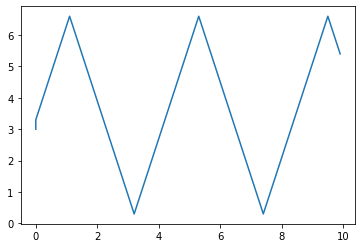

[array([3., 3.]), array([3.3, 3. ]), array([3.60000001, 3.        ]), array([3.90000001, 3.        ]), array([4.20000002, 3.        ]), array([4.50000002, 3.        ]), array([4.80000003, 3.        ]), array([5.10000003, 3.        ]), array([5.40000004, 3.        ]), array([5.70000004, 3.        ]), array([6.00000004, 3.        ]), array([6.30000005, 3.        ]), array([6.60000005, 3.        ]), array([6.30000005, 3.        ]), array([6.00000004, 3.        ]), array([5.70000004, 3.        ]), array([5.40000004, 3.        ]), array([5.10000003, 3.        ]), array([4.80000003, 3.        ]), array([4.50000002, 3.        ]), array([4.20000002, 3.        ]), array([3.90000001, 3.        ]), array([3.60000001, 3.        ]), array([3.3, 3. ]), array([3., 3.]), array([2.7, 3. ]), array([2.39999999, 3.        ]), array([2.09999999, 3.        ]), array([1.79999998, 3.        ]), array([1.49999998, 3.        ]), array([1.19999997, 3.        ]), array([0.89999997, 3.        ]), array([0.59999996

In [85]:
# prueba movimiento de una partícula sola en una dimensión
import matplotlib.pyplot as plt
t = [0]
p1 = Particula((3,3),(3,0),1,0.5)
for n in range(100):
    p1.paso_dt(0.1)  
    t.append(n*0.1)
    if p1.ver_colision_muro(7,0):
        p1.resolver_colision_muro(7,0)
        

y = []
x = []
for p in p1.posicion_n:
    x.append(p[0])
    y.append(p[1])
    
plt.plot(t,x)
plt.show()
print(p1.posicion_n)
    
       

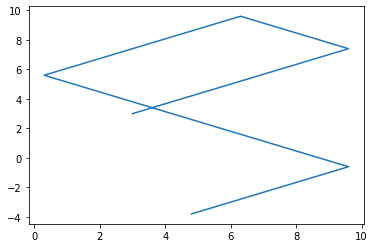

[array([3., 3.]), array([3.3, 3.2]), array([3.60000001, 3.40000001]), array([3.90000001, 3.60000001]), array([4.20000002, 3.80000001]), array([4.50000002, 4.00000001]), array([4.80000003, 4.20000002]), array([5.10000003, 4.40000002]), array([5.40000004, 4.60000002]), array([5.70000004, 4.80000003]), array([6.00000004, 5.00000003]), array([6.30000005, 5.20000003]), array([6.60000005, 5.40000004]), array([6.90000006, 5.60000004]), array([7.20000006, 5.80000004]), array([7.50000007, 6.00000004]), array([7.80000007, 6.20000005]), array([8.10000008, 6.40000005]), array([8.40000008, 6.60000005]), array([8.70000008, 6.80000006]), array([9.00000009, 7.00000006]), array([9.30000009, 7.20000006]), array([9.6000001 , 7.40000007]), array([9.30000009, 7.60000007]), array([9.00000009, 7.80000007]), array([8.70000008, 8.00000007]), array([8.40000008, 8.20000008]), array([8.10000008, 8.40000008]), array([7.80000007, 8.60000008]), array([7.50000007, 8.80000009]), array([7.20000006, 9.00000009]), array(

In [84]:
#Prueba 1 partícula en dos dimensiones
# prueba movimiento de una partícula sola en una dimensión
import matplotlib.pyplot as plt
t = [0]
p1 = Particula((3,3),(3,2),1,0.5)
for n in range(100):
    p1.paso_dt(0.1)  
    t.append(n*0.1)
    if p1.ver_colision_muro(10,10):
        p1.resolver_colision_muro(10,10)
        

y = []
x = []
for p in p1.posicion_n:
    x.append(p[0])
    y.append(p[1])
    
plt.plot(x,y)
plt.show()
print(p1.posicion_n)
    